<!-- Explanation Card -->
<style>
.explanation-card {
  max-width: 900px;
  margin: 22px auto;
  background: linear-gradient(180deg, #1e0033 0%, #0a0014 100%);
  color: #f5f5f5;
  border-radius: 16px;
  padding: 26px 32px;
  box-shadow: 0 6px 24px rgba(0,0,0,0.6);
  font-family: -apple-system, BlinkMacSystemFont, "Segoe UI", Roboto, "Helvetica Neue", Arial;
  line-height: 1.8;
  border: 1px solid rgba(255,255,255,0.12);
}
.explanation-card h2 {
  font-size: 22px;
  margin-bottom: 14px;
  font-weight: 700;
  color: #c77dff;
  display: flex;
  align-items: center;
  gap: 10px;
}
.explanation-card ul {
  margin: 0;
  padding-left: 22px;
}
.explanation-card li {
  margin-bottom: 10px;
  font-size: 15px;
}
</style>

<div class="explanation-card">
  <h2>🔎 Explanation</h2>
  <ul>
    <li><strong>Resizing & Normalization</strong> → images are resized to <code>32x32</code> and scaled to <code>[0,1]</code>.</li>
    <li><strong>Data Augmentation</strong> → improves generalization with small random shifts/rotations.</li>
    <li><strong>CNN Architecture</strong> → 3 convolutional layers + batch norm + dropout + dense layers.</li>
    <li><strong>Evaluation</strong> → accuracy curve, loss curve, confusion matrix, classification report.</li>
  </ul>
</div>


In [1]:
import os
import cv2
import PIL
import time
import zipfile
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import tensorflow as tf
import pathlib
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

2025-09-21 21:01:01.641095: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758488462.017389      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758488462.120815      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_path ="../input/traffic-sign-classification-and-recognition/train_dataset/train"
test_path ="../input/traffic-sign-classification-and-recognition/test_dataset/test/"

In [3]:
CLASSES = os.listdir(train_path)
NUM_CLASSES = len(CLASSES)

HEIGHT,WIDTH = 32,32
BATCH_SIZE = 32
SPLIT = 0.2

In [4]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    validation_split=SPLIT)


In [5]:
train_ds = train_datagen.flow_from_directory(
    train_path,
    target_size = (HEIGHT,WIDTH),
    batch_size = BATCH_SIZE,
    subset = "training",
    class_mode = "categorical",
    shuffle = True
)

Found 4823 images belonging to 10 classes.


In [6]:
val_ds = train_datagen.flow_from_directory(
    train_path,
    target_size = (HEIGHT,WIDTH),
    batch_size = BATCH_SIZE,
    subset = "validation",
    class_mode = "categorical",
    shuffle = True
)

Found 1201 images belonging to 10 classes.


In [7]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)
test_ds = test_datagen.flow_from_directory(
    test_path,
    target_size = (HEIGHT,WIDTH),
    shuffle = False
)

Found 324 images belonging to 10 classes.


In [8]:
classes = os.listdir(train_path)
print("Total Classes:", len(classes))

Total Classes: 10


In [9]:
images = []
labels = []

img_size = 32  # resize to 32x32

In [10]:
for label, folder in enumerate(classes):
    folder_path = os.path.join(train_path, folder)
    for img_name in os.listdir(folder_path):
        try:
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (img_size, img_size))
            images.append(img)
            labels.append(label)
        except:
            continue

images = np.array(images)
labels = np.array(labels)

print("Dataset Shape:", images.shape, labels.shape)


Dataset Shape: (6024, 32, 32, 3) (6024,)


In [11]:
# Normalize images
images = images / 255.0

In [12]:
# One-hot encode labels
num_classes = len(np.unique(labels))
labels_cat = to_categorical(labels, num_classes)

In [13]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(images, labels_cat, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (4819, 32, 32, 3) (4819, 10)
Test shape: (1205, 32, 32, 3) (1205, 10)


## data agumentation

In [14]:
datagen = ImageDataGenerator(rotation_range=10,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.1)

datagen.fit(X_train)

## Build CNN Model

In [15]:
model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(img_size, img_size, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

I0000 00:00:1758488521.171491      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758488521.172152      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 228,042 (890.79 KB)

 Trainable params: 227,594 (889.04 KB)

 Non-trainable params: 448 (1.75 KB)

## Train model

In [16]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                    validation_data=(X_test, y_test),
                    epochs=15)


Epoch 1/15


I0000 00:00:1758488526.805727      84 service.cc:148] XLA service 0x797c28008790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758488526.807714      84 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758488526.807736      84 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758488527.307020      84 cuda_dnn.cc:529] Loaded cuDNN version 90300


 6/76 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.2348 - loss: 3.4941

I0000 00:00:1758488531.559822      84 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


76/76 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step - accuracy: 0.6261 - loss: 1.4706 - val_accuracy: 0.4415 - val_loss: 1.6839
Epoch 2/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8585 - loss: 0.4598 - val_accuracy: 0.4274 - val_loss: 1.6864
Epoch 3/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8956 - loss: 0.3535 - val_accuracy: 0.6647 - val_loss: 1.8582
Epoch 4/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9224 - loss: 0.2620 - val_accuracy: 0.6465 - val_loss: 1.4598
Epoch 5/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9336 - loss: 0.2253 - val_accuracy: 0.7344 - val_loss: 0.9607
Epoch 6/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9333 - loss: 0.1992 - val_accuracy: 0.9012 - val_loss: 0.3869
Epoch 7/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9478 - loss: 0.1692 - val_accuracy: 0.9195 - val_loss: 0.2892
Epoch 8/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9487 - loss: 0.1725 - val_accuracy: 0.9311 - val_loss: 0

## Evaluate Model

In [17]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test Accuracy: {acc*100:.2f}%")


✅ Test Accuracy: 95.02%


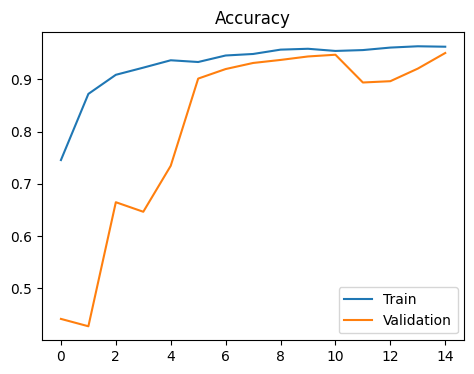

In [18]:
# Plot accuracy & loss curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.title("Accuracy")
plt.legend()

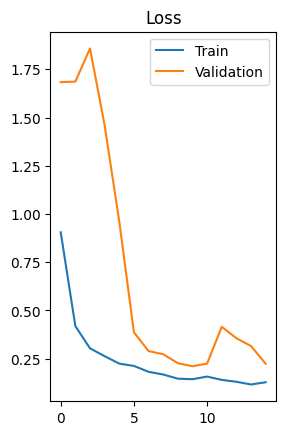

In [19]:
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.title("Loss")
plt.legend()
plt.show()

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


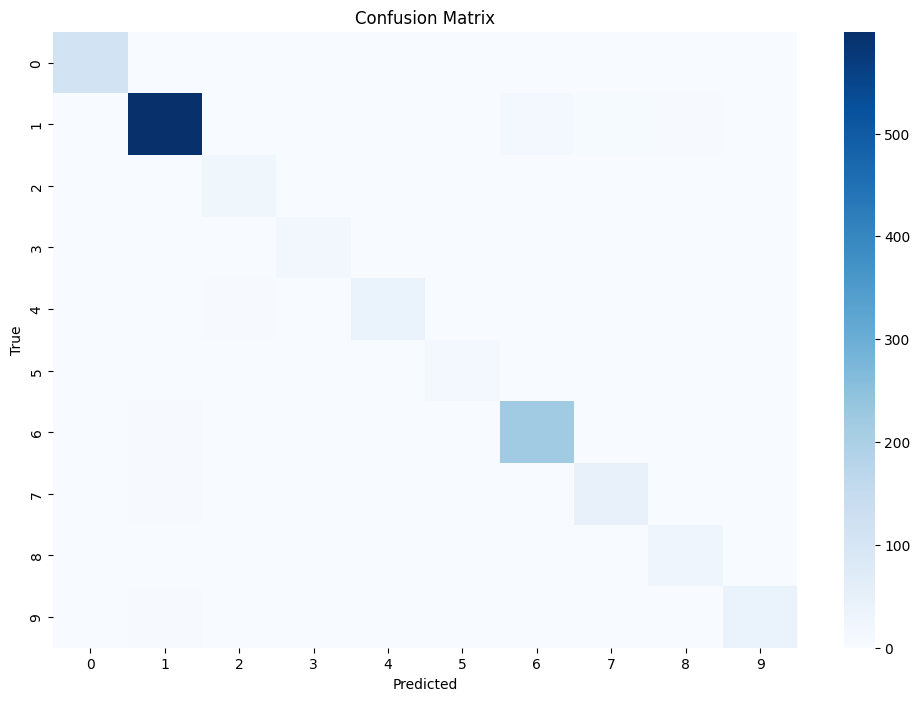

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       113
           1       0.98      0.96      0.97       626
           2       0.86      0.96      0.91        26
           3       1.00      0.95      0.98        22
           4       0.95      0.85      0.90        47
           5       0.84      1.00      0.91        16
           6       0.92      0.95      0.93       230
           7       0.87      0.88      0.88        52
           8       0.82      0.97      0.89        29
           9       0.93      0.89      0.91        44

    accuracy                           0.95      1205
   macro avg       0.91      0.94      0.93      1205
weighted avg       0.95      0.95      0.95      1205



In [20]:
# Confusion Matrix

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true, y_pred))

## Predict Random Data 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


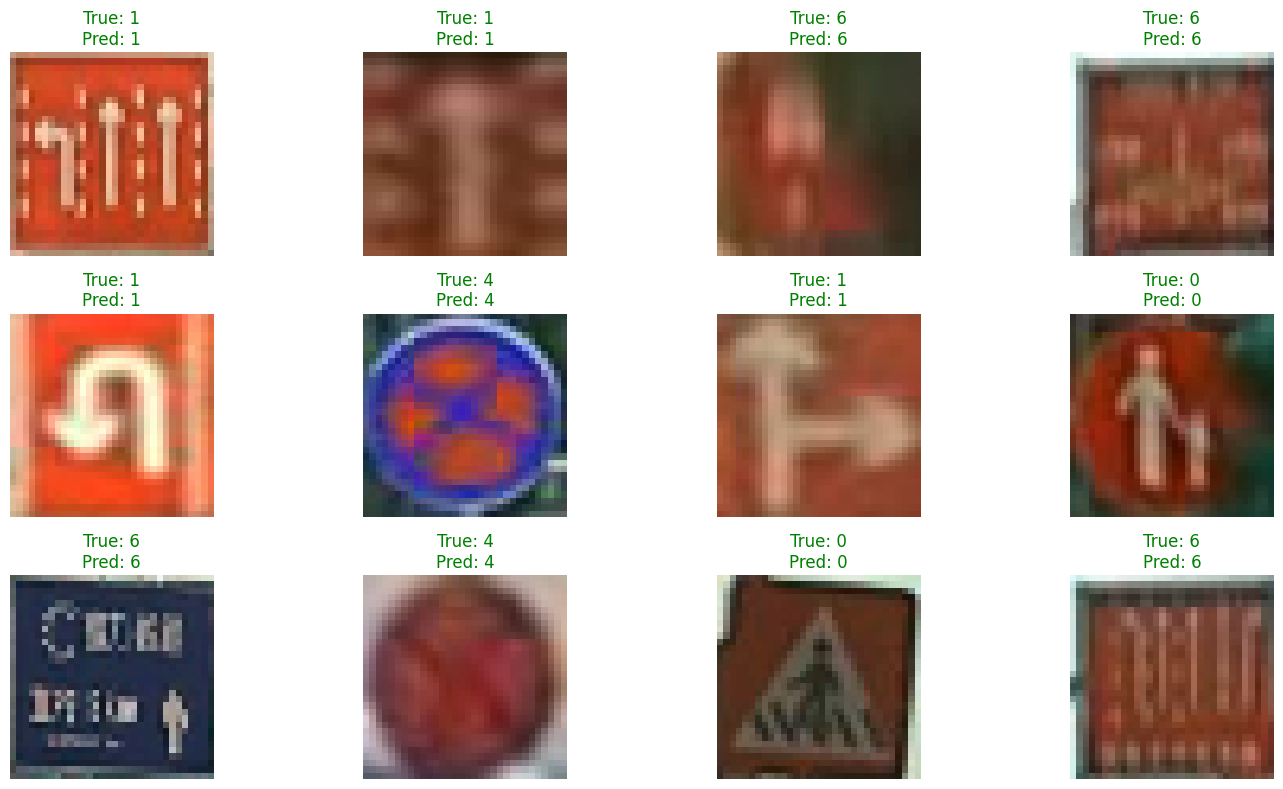

In [21]:
import random

# Pick random samples from test set
indices = random.sample(range(len(X_test)), 12)

plt.figure(figsize=(15, 8))
for i, idx in enumerate(indices):
    plt.subplot(3, 4, i+1)
    
    img = X_test[idx]
    true_label = np.argmax(y_test[idx])
    pred_label = np.argmax(model.predict(img.reshape(1, img_size, img_size, 3)))
    
    plt.imshow(img)
    plt.axis("off")
    color = "green" if true_label == pred_label else "red"
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)

plt.tight_layout()
plt.show()


## Save Model

In [22]:
# Save model
model.save("traffic_sign_cnn.h5")

# Load model later
#from tensorflow.keras.models import load_model
#loaded_model = load_model("traffic_sign_cnn.h5")

# Test it works
#loss, acc = loaded_model.evaluate(X_test, y_test, verbose=0)
#print(f"Loaded model accuracy: {acc*100:.2f}%")
